<a href="https://colab.research.google.com/github/leonstayhun/programme-1/blob/master/01_Image_Restoration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is adapted from **https://github.com/juglab/n2v**
In this notebook, we will denoise some Scanning Electron Microscopy Images using an approach called Noise2Void.  
Through this notebook, you will see the complete workflow of an DL approach - (i) data preparation, followed by (ii) training the model and finally (iii) applying the trained model on the test, microscopy images.  
You will find some questions (indicated as `Q`s) for discussion in blue boxes in this notebook :)  
<hr>
Prior to running this notebook, you need to have the correct environment configured. 

#### If not running on google colab
Open a fresh terminal window and run the following commands:

>conda create -n 'dl-biapol' python=3.7  
conda activate dl-biapol  
pip install tensorflow-gpu=2.4.1 keras=2.3.1 n2v jupyter  scikit-image gputools

Finally open this notebook using `jupyter notebook`

#### If running on google colab
Go to `File>Upload Notebook` and drag and drop this notebook.  
Go to `Runtime > Change Runtime Type > Hardware Accelerator = GPU`  
Create an empty cell following this one and run:
>!pip install tensorflow-gpu==2.4.1 keras==2.3.1  n2v scikit-image gputools


In [ ]:
!pip install tensorflow-gpu==2.4.1 keras==2.3.1 n2v scikit-image gputools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 377 kB 65.3 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 152 kB 73.5 MB/s 
     |████████████████████████████████| 132 kB 64.2 MB/s 
     |████████████████████████████████| 462 kB 70.7 MB/s 
     |████████████████████████████████| 3.8 MB 52.6 MB/s 
     |████████████████████████████████| 2.9 MB 52.1 MB/s 
     |████████████████████████████████| 14.8 MB 58.3 MB/s 
     |████████████████████████████████| 50 kB 8.2 MB/s 
     |████████████████████████████████| 73 kB 2.1 MB/s 
     |████████████████████████████████| 109 kB 63.5 MB/s 
     |████████████████████████████████| 31.0 MB 1.2 MB/s 
     |████████████████████████████████| 546 kB 74.6 MB/s 
     |████████████████████████████████| 932 kB 66.2 MB/s 
     |██████████████████████████████

### Get imports

>We import all our dependencies.

In [ ]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
from tifffile import imread
import urllib, os, zipfile, ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Download example data

>Data by Reza Shahidi and Gaspar Jekely, Living Systems Institute, Exeter.  
You could try opening the <i> train.tif </i> and <i> validation.tif </i> in Fiji.

In [ ]:
# create a folder for our data.
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath="data/SEM.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/SEM.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")



### Training Data Preparation

>For training we load one set of low-SNR images and use the `N2V_DataGenerator` to extract training `X` and validation `X_val` patches.  

In [ ]:
datagen = N2V_DataGenerator()

>We load all the `.tif` files from the `data` directory.  
The function will return a list of images (numpy arrays).

In [ ]:
imgs = datagen.load_imgs_from_directory(directory = "data/")

>Let us look at the images.  
We have to remove the added extra dimensions to display them as `2D` images.

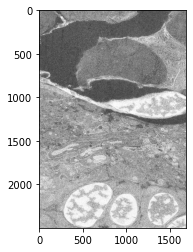

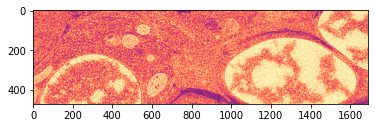

In [ ]:
plt.imshow(imgs[0][0,...,0], cmap='gray')
plt.show()

plt.imshow(imgs[1][0,...,0], cmap='magma')
plt.show()

>We will use the first image to extract training patches and store them in `X`.  
We will use the second image to extract validation patches.

### Training

In [ ]:
patch_shape = (96,96)
X = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)
X_val = datagen.generate_patches_from_list(imgs[1:], shape=patch_shape)

Generated patches: (3536, 96, 96, 1)
Generated patches: (544, 96, 96, 1)


<div class="alert alert-block alert-info"> Q:<b> Why do you think input images chopped into smaller patches? </b>.<br>
    What could be different schemes for extracting patches? 
</div>

>Using `N2VConfig` we specify some training parameters.  
For example, `train_epochs` is set to $20$ to indicate that training runs for $20$ epochs. 

In [ ]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

>`model_name` is used to identify the model.   
`basedir` is used to specify where the trained weights are saved.  
We shall now create our network model by using the `N2V` method.

<div class="alert alert-block alert-info"> Q: <b> Can you identify what is the default learning rate used while  training the N2V model? </b>.<br>
<u> HINT </u> Pressing <i> Shift + Tab </i> shows the docstring for a given function
</div>

<div class="alert alert-block alert-info"> Q: <b> Is it advantageous to set a high batch size? How about a low batch size? </b><br> 
Also, discuss what would setting <i>BatchNorm = True</i> imply? 
</div>


In [ ]:
model_name = 'n2v_2D'
basedir = 'models'
model = N2V(config, model_name, basedir=basedir)

>Running `model.train` will begin the training for $20$ epochs.  
Training the model will likely take some time.  

In [ ]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 544/544 [00:00<00:00, 1162.70it/s]


Epoch 1/20
 6/27 [=====>........................] - ETA: 2s - loss: 0.6169 - n2v_mse: 0.6169 - n2v_abs: 0.6360

27/27 [==============================] - 4s 131ms/step - loss: 0.5972 - n2v_mse: 0.5972 - n2v_abs: 0.6246 - val_loss: 0.5572 - val_n2v_mse: 0.5572 - val_n2v_abs: 0.5873
Epoch 2/20
27/27 [==============================] - 3s 128ms/step - loss: 0.6030 - n2v_mse: 0.6030 - n2v_abs: 0.6278 - val_loss: 0.5571 - val_n2v_mse: 0.5571 - val_n2v_abs: 0.5965
Epoch 3/20
27/27 [==============================] - 3s 129ms/step - loss: 0.5948 - n2v_mse: 0.5948 - n2v_abs: 0.6231 - val_loss: 0.5549 - val_n2v_mse: 0.5549 - val_n2v_abs: 0.5801
Epoch 4/20
27/27 [==============================] - 3s 130ms/step - loss: 0.6091 - n2v_mse: 0.6091 - n2v_abs: 0.6304 - val_loss: 0.5562 - val_n2v_mse: 0.5562 - val_n2v_abs: 0.5807
Epoch 5/20
27/27 [==============================] - 3s 130ms/step - loss: 0.6004 - n2v_mse: 0.6004 - n2v_abs: 0.6243 - val_loss: 0.5542 - val_n2v_mse: 0.5542 - val_n2v_abs: 0.5865
Epoch 6/20
27/27 [==============================] - 4s 130ms/step - loss: 0.6000 - n2v_mse: 0.6000 - n2v_abs: 0

<div class="alert alert-block alert-info"> Q: <b> What do you think is the difference between <i>n2v_mse</i> and <i>n2v_abs</i>? </b>.<br>
Also, the last line which is printed out is <i>Loading network weights from 'weights_best.h5'</i>. What defines the <u> best </u> state of the model?
</div>

### Inference

>We load the data we want to process within `input_val`.  
The parameter `n_tiles` can be used if images are to big for the GPU memory. 

In [ ]:
input_val = imread('data/validation.tif')
pred_val = model.predict(input_val, axes='YX')

>Let's see results on the validation data. (First we look at the complete image and then we look at a zoomed-in view of the image)

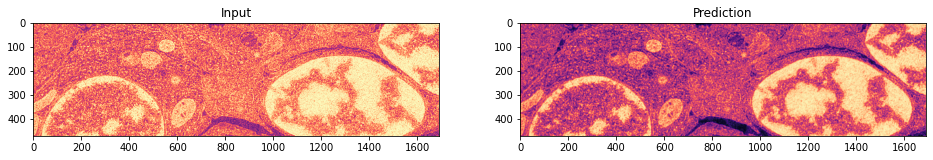

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_val,cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_val,cmap="magma")
plt.title('Prediction');

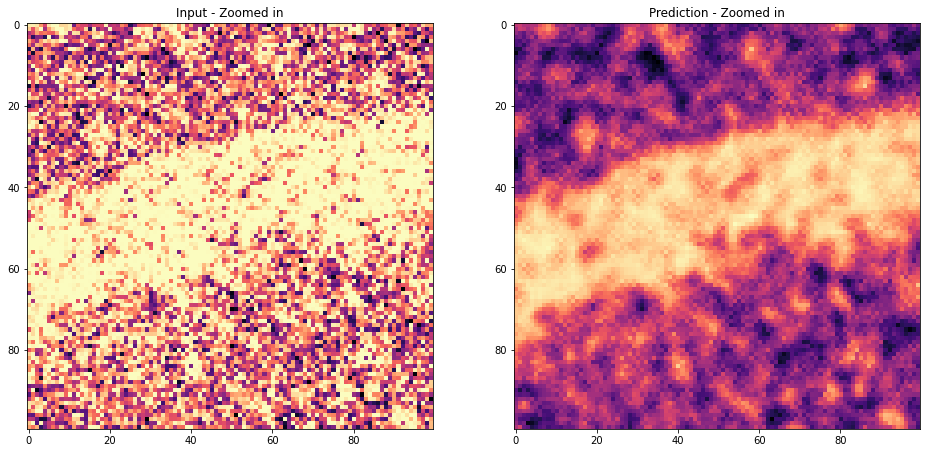

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_val[200:300, 200:300],cmap="magma")
plt.title('Input - Zoomed in');
plt.subplot(1,2,2)
plt.imshow(pred_val[200:300, 200:300],cmap="magma")
plt.title('Prediction - Zoomed in');

<div class="alert alert-block alert-info"> Q: <b> We demonstrated microscopy image denoising with this N2V notebook where we first trained a model and later applied the trained model on validation images. </b> <br>
    Would you call this a <i>supervised</i> learning approach, an <i>unsupervised</i> learning approach or something else? Discuss! :)